# 线性回归的从零开始实现
 - 前面为数据准备阶段 已经省略

## 定义初始化模型参数（直接跳过）

features: tensor([1.1766, 0.4305]) 
label: tensor([5.0845])
tensor([[ 1.1403,  0.8364],
        [ 0.7587, -0.0337],
        [ 1.1858,  0.6379],
        [ 1.9851,  0.2548],
        [-0.5134,  0.0065],
        [ 0.9011,  0.3142],
        [-0.5955,  0.6487],
        [-0.1436,  1.1836],
        [ 0.5502, -0.2830],
        [ 1.5695, -0.3483]]) 
 tensor([[ 3.6450],
        [ 5.8207],
        [ 4.4040],
        [ 7.3021],
        [ 3.1632],
        [ 4.9436],
        [ 0.7957],
        [-0.1163],
        [ 6.2545],
        [ 8.5263]])


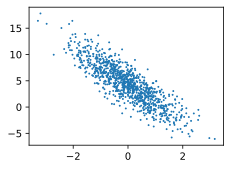

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

## 定义初始化模型参数（看懂逻辑但不用背）


In [2]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)# requires_grad=True 表示它需要梯度，用于反向传播。创建形状为 (2, 1) 的张量，元素从均值为 0、标准差为 0.01 的正态分布中采样
b = torch.zeros(1, requires_grad=True)

## 告诉了参数以后 现在的问题是告诉AI以后如何处理数据？也就是用什么模型？ 
 *因此需要定义模型* 
 - 告诉有什么参数


In [3]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

## [**定义损失函数**]

In [4]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

## (**定义优化算法**)

In [5]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -=lr* param.grad/batch_size
            param.grad.zero_()
            #为什么要 / batch_size？ 因为我
            #们前面算 Loss 的时候，是把 10 个零件（一
            #个 batch）的误差加在一起算的。为了公平，我们要除以10
            #求出一个平均梯度，拿这个平均值去更新参数，这样步伐才走得稳
            #在真正运行这个sgd函数的时候,我们会把这两个参数**打包成一个列表
#(List)**扔进这个函数里。也就是说,这个时候的 params 其实长这样 [w, b]

In [6]:
# 开始训练
#制定参数
lr = 0.025
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.099759
epoch 2, loss 0.000666
epoch 3, loss 0.000055
w的估计误差: tensor([ 0.0003, -0.0026], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0013], grad_fn=<RsubBackward1>)
